# Notebook description
<!---define operatorname var-->
$\DeclareMathOperator{\Var}{Var}$
<!---define operatorname var-->

This notebook looks at the signal to noise ratio (SNR) of a synapse with input spike train with frequency $\lambda$ and interspike intervals (ISIs) following a Gamma distribition.

The pdf of the gamma distribution is given by
$$
f_X(x) = \frac{\lambda^k}{\Gamma(k)}x^{k-1}e^{-\lambda x}
$$

We are particularly interested in cases when $k$ is a positive integer, in which case

$$
f_X(x) = \frac{\lambda^k}{(k-1)!}x^{k-1}e^{-\lambda x}
$$

which is the pdf of the Erlang distribution.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gamma
import scipy

s = np.random.seed(2)
rng = np.random.RandomState(s)

# Summary of results

<div style="display:block; border: 1px solid black; padding: 15px;background-color: #EEEEFF;margin: 10px">
\begin{align*}
E[X] &= \\
\Var(X) &=  \\
SNR &=  \\
\end{align*}
</div>

# Derivations

We know from considering a filtered renewal process with a different first interval distribution (see [here](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/theory/filtered_renewal_processes.ipynb#Filtered-renewal-process-with-different-first-interval)) that 

\begin{align*}
E[X] &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-T/\tau}\right]^i \\
E[X^2] &= \frac{1}{\tau^2}E\left[e^{-2T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-2T/\tau}\right]^i
    \left(1 + 2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^j\right) \\
\end{align*}

The first interval $T_1$ can be decomposed as $T_1=UT^*$ where $U$ and $T^*$ are independent, $U\sim\mathrm{Uniform}(0,1)$, and $T^*$ is a random variable describing the length of the interval containing the point in time of the synapse we're considering. Surprisingly, $T^*\neq T$. This is known as the [inspection paradox](http://en.wikipedia.org/wiki/Renewal_theory#The_inspection_paradox), a result from a field called renewal theory. Rather, the PDF of $T^*$ is given by

$$
f_{T^*}(t)=\frac{tf_T(t)}{E[T]}
$$

so the PDF of $T_1$ ends up bing

$$
f_{T_1}(t)=\frac{1-F_T(t)}{E[T]}
$$

## Synapse mean

\begin{align*}
E[X] &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-T/\tau}\right]^i \\
 &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{ki} \\
 &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]
    \frac{1}{1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{k}} \\
 &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]
    \frac{(1+\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

This is as far as I can go until getting a handle on $E\left[e^{-T_1/\tau}\right]$...

## Synapse variance

## Synapse SNR

In [39]:
def th_mean(lam, k, tau):
    pass

def th_mean_memoryless(lam, k, tau):
    x = lam*tau
    ret = x**k/((1+x)**k-x**k)/tau
    return ret

def th_mean_no_bias(lam, k, tau):
    x = lam*tau
    a = lam/(k-1)
    b = 1+x
    c_num = (1+x)**(k-1)-x**(k-1)
    c_den = (1+x)**k-x**k
    c = c_num/c_den
    ret = a*b*c
    return ret

def approx_mean(lam, k):
    return lam/k

##########

def th_var_memoryless(lam, k, tau):
    x = lam*tau
    a = 1./tau**2
    
    b = x**k/((1+x)**k-x**k)**2  # last expression for Var(X)
    c_num = (1+x)**(2*k) - x**k*(2+x)**k
    c_den = (2+x)**k - x**k
    c = c_num/c_den
    ret = a*b*c
    
#     a = x**k/tau**2  # mathematica simplified expression for Var(X)
#     b = 1./(x**k-(1+x)**k)**2
#     c_num = x**k*(2+x)**k-(1+x)**(2*k)
#     c_den = x**k-(2+x)**k
#     c = c_num/c_den
#     ret = a*b*c

    return ret

def th_var_no_bias(lam, k, tau):
    pass

##########

# def th_snr_memoryless(lam, k, tau):
#     x = lam*tau
#     num = -(x)**(2*k) + x**k*(2+x)**k
#     den = (1+x)**(2*k) - x**k*(2+x)**k
#     ret = np.sqrt(num/den)
#     return ret

def get_snr(mu, var):
    return mu/np.sqrt(var)

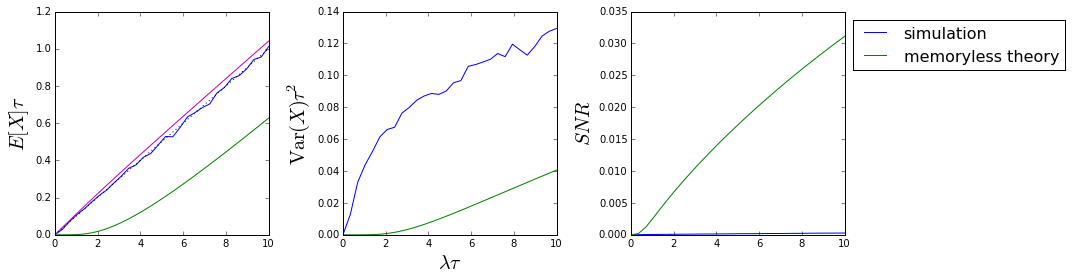

In [46]:
def check_theory(lams, k, tau=.01, n_tau_ss=10, n_tau=30, n_samples=100, n_trials=300):
    min_nspikes = 100
    nfreqs = len(lams) # number of frequencies to test
    mean_obs = np.zeros(nfreqs)
    var_obs = np.zeros(nfreqs)

    for lam_idx, lam in enumerate(lams):
        nspikes = max(2*int(n_tau*tau*lam/float(k)), min_nspikes)
        isi = rng.gamma(k, 1./lam, (n_trials, nspikes))
        spike_times = np.cumsum(isi, axis=1)
        x = np.zeros((n_trials, n_samples))
        obs_trial_mean = np.zeros(n_trials)
        for trial_idx in xrange(n_trials):
            t_samples = rng.uniform(0., spike_times[trial_idx][-1]-n_tau_ss*tau, n_samples)
            for sample_idx, t in enumerate(t_samples):
                tp = spike_times[trial_idx]-t
                tp = tp[tp>=0]
                x[trial_idx, sample_idx] = np.sum(np.exp(-tp[tp>=0]/tau))/tau
        mean_obs[lam_idx] = np.mean(x)
        var_obs[lam_idx] = np.var(x)
    snr_obs = get_snr(mean_obs, var_obs)

#     mean_th = th_mean(lams, k, tau)
    mean_th_memoryless = th_mean_memoryless(lams, k, tau)
    mean_th_no_bias = th_mean_no_bias(lams, k, tau)
    mean_approx = approx_mean(lams, k)
    
    var_th_memoryless = th_var_memoryless(lams, k, tau)
    
    snr_th_memoryless = get_snr(mean_th_memoryless, var_th_memoryless)
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4), sharex=True)
    x = lams*tau
    axs[0].plot(x, mean_obs*tau, 'b', label='simulation')
#     axs[0].plot(lt, mean_th*tau, 'r', label='theory')
    axs[0].plot(x, mean_th_memoryless*tau, 'g', label='memoryless theory')
    axs[0].plot(x, mean_th_no_bias*tau, 'm', label='no bias theory')
    axs[0].plot(x, mean_approx*tau, 'k:', label='approx')
    axs[0].set_ylabel(r'$E[X]\tau$', fontsize=20)
    
    axs[1].plot(x, var_obs*tau**2, 'b', label='simulation')
    axs[1].plot(x, var_th_memoryless*tau**2, 'g', label='memoryless theory')
    axs[1].set_xlabel(r'$\lambda\tau$', fontsize=20)
    axs[1].set_ylabel(r'$\operatorname{Var}(X)\tau^2$', fontsize=20)
    
    axs[2].plot(x, snr_obs*tau**2, 'b', label='simulation')
    axs[2].plot(x, snr_th_memoryless*tau, 'g', label='memoryless theory')
    axs[2].legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=16)
    axs[2].set_ylabel(r'$SNR$', fontsize=20)
    plt.tight_layout()

lams = np.linspace(1, 1000, 30)
check_theory(lams, k=10, n_trials=1000, n_samples=1)

# Assuming unbiased first interval

Accounting for the bias in $T^*$ produces a distribution that's hard to analyze, here, we assume that $T^*$ follows the same distribution as $T$.

## Synapse mean

\begin{align*}
E[X] &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-T/\tau}\right]^i \\
 &= \frac{1}{\tau}E\left[\frac{\tau}{T}\left(1-e^{-T/\tau}\right)\right]
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{ki} \\
 &= \frac{\lambda}{k-1}\left(\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(1+\lambda\tau)^{k-1}}\right)
    \frac{1}{1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{k}} \\
 &= \frac{\lambda}{k-1}\left(\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(1+\lambda\tau)^{k-1}}\right)
    \frac{\left(1+\lambda\tau\right)^k}{\left(1+\lambda\tau\right)^k-\left(\lambda\tau\right)^k} \\
 &= \frac{\lambda(1+\lambda\tau)}{k-1}\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

##Synapse variance

\begin{align*}
E[X^2] &= \frac{1}{\tau^2}E\left[e^{-2T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-2T/\tau}\right]^i
    \left(1 + 2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^j\right) \\
&= \frac{1}{\tau^2}E\left[\frac{\tau}{2T}\left(1-e^{-2T/\tau}\right)\right]
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{2+\lambda\tau}\right)^{ki}
    \left(1 + 2\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
&= \frac{1}{\tau}\left(
    \frac{\lambda}{2(k-1)}
    \frac{(2+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(2+\lambda\tau)^{k-1}}\right)
    \frac{(2+\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
&= \frac{\lambda}{\tau}\frac{(2+\lambda\tau)}{2(k-1)}\left(
    \frac{(2+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(2+\lambda\tau)^k-(\lambda\tau)^k}\right)
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
\end{align*}

##Synapse SNR

---

# Assuming process is memoryless

It's hard to account for the nonmemorylessness of the gamma renewal process. Here we compute the synaptic statistics assuming it is memoryless. This will give us approximations to the actual statistics.

## Synapse mean

\begin{align*}
E[X] &= \frac{1}{\tau}\sum_{i=1}^\infty E\left[e^{-T/\tau}\right]^i \\
 &= \frac{1}{\tau}\sum_{i=1}^\infty \left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{ki} \\
 &= \frac{1}{\tau}\frac{\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k}
    {1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k} \\
 &= \frac{1}{\tau}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

## Syanpse variance

\begin{align*}
E[X^2] &= \frac{1}{\tau^2}\sum_{i=1}^{\infty}E\left[e^{-2T/\tau}\right]^i\left(1 +
    2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^{j}\right) \\
 &=  \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}\left(1 +
    2\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}
    \frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

\begin{align*}
\Var(X) &= E[X^2] - E[X]^2 \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}
    \frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{1}{\tau^2}\left(\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right)^2 \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}
    \left(\frac{\left((1+\lambda\tau)^k+(\lambda\tau)^k\right)\left((1+\lambda\tau)^k-(\lambda\tau)^k\right) -
    (\lambda\tau)^k\left((2+\lambda\tau)^k-(\lambda\tau)^k\right)}
    {\left((2+\lambda\tau)^k-(\lambda\tau)^k\right)\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)^2}
    \left(\frac{(1+\lambda\tau)^{2k}-(\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k+(\lambda\tau)^{2k}}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)^2}
    \left(\frac{(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
\end{align*}

## Synapse SNR

\begin{align*}
SNR &= \frac{E[X]}{\sqrt{\Var(X)}} \\
 &= \frac{\frac{1}{\tau}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}}
    {\sqrt{\frac{1}{\tau^2}\frac{(\lambda\tau)^k}{\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)^2}
    \left(\frac{(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}\right)}} \\
 &= \frac{\sqrt{(\lambda\tau)^k}}
    {\sqrt{
    \frac{(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}}} \\
 &= \sqrt{\frac{-(\lambda\tau)^{2k}+(\lambda\tau)^k(2+\lambda\tau)^k}
    {(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}} \\
\end{align*}

---
# Appendix

## Supplementary proofs

For $E\left[e^{-2T/\tau}\right]$ and $E\left[e^{-T/\tau}\right]$, or rather $E\left[e^{-cT/\tau}\right]$.

\begin{align*}
E[e^{-cT/\tau}] &= \int_{-\infty}^{\infty}e^{-ct/\tau}f_T(t)dt \\
 &= \int_{0}^{\infty}e^{-ct/\tau}\frac{\lambda^k}{\Gamma(k)}t^{k-1}e^{-\lambda t}dt \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}t^{k-1}e^{-ct/\tau}e^{-\lambda t}dt \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}t^{k-1}e^{-t(c/\tau+\lambda)}dt \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}\left(\frac{\tau}{c+\lambda\tau}u\right)^{k-1}
     e^{-u}\frac{\tau}{c+\lambda\tau}du & u = t(c/\tau+\lambda) \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}\left(\frac{\tau}{c+\lambda\tau}\right)^ku^{k-1}e^{-u}du \\
 &= \frac{\lambda^k}{\Gamma(k)}\left(\frac{\tau}{c+\lambda\tau}\right)^k\int_{0}^{\infty}u^{k-1}e^{-u}du \\
 &= \frac{\lambda^k}{\Gamma(k)}\left(\frac{\tau}{c+\lambda\tau}\right)^k\Gamma(k) \\
 &= \left(\frac{\lambda\tau}{c+\lambda\tau}\right)^k \\
\end{align*}

---

Assuming $T^*\sim T$, so that $T_1=UT$ where $U\sim\mathrm{Uniform}(0,1)$,

\begin{align*}
E\left[e^{-cT_1/\tau}\right] &= E\left[e^{-cUT/\tau}\right] \\
 &= E\left[E\left[e^{-cUT/\tau}|T\right]\right] \\
 &= E\left[\int_0^1e^{-cuT/\tau}du\right] \\
 &= E\left[-\frac{\tau}{cT}\left[e^{-cuT/\tau}\right]_0^1\right] \\
 &= E\left[\frac{\tau}{cT}\left(1-e^{-cT/\tau}\right)\right] \\
\end{align*}

---

\begin{align*}
E\left[\frac{1}{cT}\left(1-e^{-cT/\tau}\right)\right] &= 
    \int_{-\infty}^{\infty}\frac{1}{ct}\left(1-e^{-ct/\tau}\right)f_T(t)dt \\
 &= \int_0^{\infty}\frac{1}{ct}\left(1-e^{-ct/\tau}\right)
    \frac{\lambda^k}{\Gamma(k)}t^{k-1}e^{-\lambda t}dt \\
 &= \frac{\lambda^k}{c\Gamma(k)}\int_0^{\infty}\frac{1}{t}\left(1-e^{-ct/\tau}\right)
    t^{k-1}e^{-\lambda t}dt \\
 &\ldots & \mathrm{Mathematica} \\
 &= \frac{\lambda^k}{c\Gamma(k)}\frac{\Gamma(k-1)}{\lambda^{k-1}}
    \frac{(c+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(c+\lambda\tau)^{k-1}} \\
 &= \frac{\lambda}{c(k-1)}
    \frac{(c+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(c+\lambda\tau)^{k-1}} \\
\end{align*}

---

## Verification of expected values

Verify that

$$
\frac{1}{\tau}E[e^{T_1/\tau}]=
    E\left[\frac{1}{T}\left(1-e^{-T/\tau}\right)\right]=
    \frac{\lambda}{k-1}\left(\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(1+\lambda\tau)^{k-1}}\right) \\
$$

relative (to mean_th) differences
mean_th - mean_obs_T1    = +0.005076
mean_th - mean_obs_T     = +0.003388
mean_obs_T1 - mean_obs_T = -0.001688


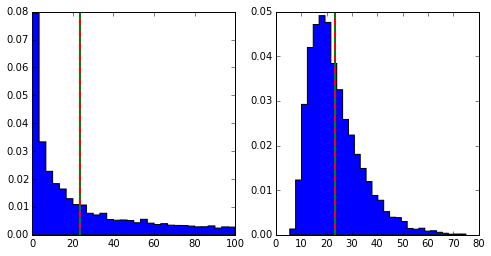

In [30]:
def check_E_first_decay(lam, k, tau=0.01, n_trials=1000):
    t = rng.gamma(k, 1./lam, n_trials)
    x_T = (1.-np.exp(-t/tau)) / t
    mean_obs_T1 = np.mean(x_T)
    
    t = rng.gamma(k, 1./lam, n_trials)
    tfrac = rng.uniform(0, 1, n_trials)
    t1 = t - t*tfrac
    x_T1 = np.exp(-t1/tau)/tau
    mean_obs_T = np.mean(x_T1)
    
    a = (1+lam*tau)**(k-1.)
    mean_th = lam/(k-1.) * ((a-(lam*tau)**(k-1.))/a)
    
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.hist(x_T1, bins=30, histtype='stepfilled', normed=True)
    plt.axvline(mean_th, c='r', lw=2)
    plt.axvline(mean_obs_T1, c='g', ls='--', lw=2)
    plt.subplot(122)
    plt.hist(x_T, bins=30, histtype='stepfilled', normed=True)
    plt.axvline(mean_th, c='r', lw=2)
    plt.axvline(mean_obs_T, c='g', ls='--', lw=2)
    
    print 'relative (to mean_th) differences'
    print 'mean_th - mean_obs_T1    = %+f' % ((mean_th - mean_obs_T1) / mean_th)
    print 'mean_th - mean_obs_T     = %+f' % ((mean_th - mean_obs_T) / mean_th)
    print 'mean_obs_T1 - mean_obs_T = %+f' % ((mean_obs_T1 - mean_obs_T) / mean_th)

check_E_first_decay(lam=100., k=5., n_trials=10000)

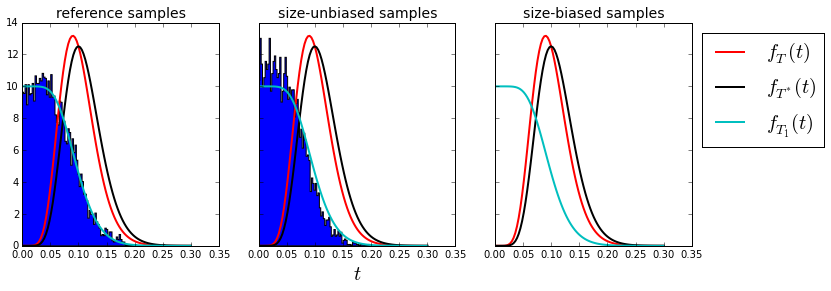

In [26]:
def check_T1(lam, k, n_trials=5000, n_intervals=10000):
    # generate spike times
    # sample within time to pick T1
    isi = rng.gamma(k, 1./lam, n_intervals)
    spike_times = np.cumsum(isi)
    t_vals = rng.uniform(0, spike_times[-1], n_trials)
    t1 = np.zeros(n_trials)
    for idx, t in enumerate(t_vals):
        x = spike_times-t
        t1[idx] = x[x>=0][0]
    
    # sample gamma to generate an interval
    # sample from uniform within that gama to generate t
    t = rng.gamma(k, 1./lam, n_trials)
    tfrac = rng.uniform(0, 1, n_trials)
    t1_unbiased = t*tfrac
    
    t1_biased = None
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4), sharex=True, sharey=True)
    
    axs[0].hist(t1, bins=100, histtype='stepfilled', normed=True)
    axs[1].hist(t1_unbiased, bins=100, histtype='stepfilled', normed=True)
    
    rv = gamma(k, scale=1./lam)
    xlims = axs[0].get_xlim()
    T = np.linspace(xlims[0], xlims[1], 100)
    T_pdf = rv.pdf(T)
    Tb_pdf = T*T_pdf/rv.mean()
    T1_pdf = (1-rv.cdf(T))/rv.mean()
    for ax in axs:
        ax.plot(T, T_pdf, 'r', lw=2, label=r'$f_T(t)$')
        ax.plot(T, Tb_pdf, 'k', lw=2, label=r'$f_{T^*}(t)$')
        ax.plot(T, T1_pdf, 'c', lw=2, label=r'$f_{T_1}(t)$')
    
    axs[2].legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=20)
    axs[1].set_xlabel(r'$t$', fontsize=20)
    axs[0].set_title('reference samples', fontsize=14)
    axs[1].set_title('size-unbiased samples', fontsize=14)
    axs[2].set_title('size-biased samples', fontsize=14)
    
    
check_T1(100, 10)